## Prueba tecnica Científico de Datos Gerencia Tecnica en Inteligencia Artificial

### Centro de Excelencia Analítica, Inteligencia Artificial y Gobierno de la Información
### Vicepresidencia de Analítica, Datos e Inteligencia Artificial

Julian David Rivera Hoyos
#### Pasos:
- Realizar embedding sobre el entrenamiento para validar la eficienciad del modelo encontrando los documentos relevantes y comprombar la medida de MMR
- Se realiza un embedding sobre el modelo de Open AI text-embedding-ada-002 para el test query y test document
- Se crea el algoritmo para evaluar cosine similarity entre el query test embedding y el document test embedding y recuperar los 10 mejores resultados
    en cuanto a esta metrica.
Notas: Se realizo la prueba tambien con un modelo de tokenizacion y embebido de bert donde La media de los MMR es : 0.33875.
        Se considero construir un modelo proprio atravez de el algoritmo basado en el paper "Attention is all you need" (transformer) realizando una tokenizacion y embedding propio pero dado el rendimiendo bajo de bert en comparacion con ada-v2, para obtener un resultado similar a la referencia ada-v2 con un modelo propio se requiere una mayor conjunto de entremiento de procesamiento, y tiempo de estudio para la construccion de este, por tanto se obta por la solucion inicial.

#### Referencias:

- https://platform.openai.com/docs/guides/embeddings
- https://learn.microsoft.com/en-us/azure/ai-services/openai/tutorials/embeddings?tabs=python%2Ccommand-line&pivots=programming-language-python
- https://www.tensorflow.org/text/tutorials/transformer
- https://www.tensorflow.org/text/guide/subwords_tokenizer


### Embeddings OPEN AI text-embedding-ada-002


In [1]:
import pandas as pd
import openai
import json
from openai.embeddings_utils import get_embedding, cosine_similarity
import tiktoken
import os

In [2]:
SECRET_KEY= os.getenv("SECRET_KEY_OPENAI")
openai.api_key = SECRET_KEY

#### Cargue de informacion y validaciones

In [6]:
# Cargar datos de entrenamiento
train_data = pd.read_csv('./Insumos/train.csv')
test_query_data = pd.read_csv('./Insumos/test_queries.csv')
test_documents_data = pd.read_csv('./Insumos/test_documents.csv')
print(train_data.shape)


(4000, 3)


In [7]:
###### validacion tokens documentos y querys evitar error en la base de train
tokenizer = tiktoken.get_encoding("cl100k_base")
train_data['n_tokens_documents'] = train_data["document"].apply(lambda x: len(tokenizer.encode(x)))
train_data = train_data[train_data.n_tokens_documents<8192]

train_data['n_tokens_query'] = train_data["query"].apply(lambda x: len(tokenizer.encode(x)))
train_data = train_data[train_data.n_tokens_query<8192]
len(train_data)


4000

#### Embedding query y document revisar eficiencia modelo evaludacion sobre train (on premise)

In [50]:
### Embedding de docuemntos y querys 26 min y 0.05 dolares 8000 llamados
train_data['ada_v2'] = train_data["document"].apply(lambda x : get_embedding(x, engine = 'text-embedding-ada-002')) 
train_data['ada_query_v2'] = train_data["query"].apply(lambda x : get_embedding(x, engine = 'text-embedding-ada-002'))

In [ ]:
### copia del train data
train_datacopy= train_data.copy()

In [106]:
# Busqueda del documento con mayor simulitud y ranqueo
def search_docs_onprimse(df, user_query, top_n=3, to_print=True):
    embedding = df.query(f'query=="{user_query}"')\
                    [['query','ada_query_v2']].drop_duplicates(subset='query')\
                    .ada_query_v2.values[0]
    df["similarities"] = df.ada_v2.apply(lambda x: cosine_similarity(x, embedding))

    res = (
        df.sort_values("similarities", ascending=False)
        .head(top_n)
    )
    if to_print:
        display(res)
    return res

In [123]:
### prueba de la funcion
respuesta= search_docs_onprimse(train_datacopy,'Sprint pagar por teléfono número de teléfono', top_n=10)

,query,document,label,n_tokens,ada_v2,similarities,n_tokens_documents,n_tokens_query,ada_query_v2
2037,Sprint pagar por teléfono número de teléfono,"Una vez hecho esto, llamé a Sprint y pagué el ...",0,227,"[-0.024288080632686615, -0.008756246417760849,...",0.879989,227,10,"[-0.02328476868569851, -0.0063414848409593105,..."
1258,Sprint pagar por teléfono número de teléfono,Pague en Western Union Pague en efectivo en un...,0,60,"[-0.02454003505408764, 0.0006356459925882518, ...",0.878386,60,10,"[-0.02328476868569851, -0.0063414848409593105,..."
2862,Sprint pagar por teléfono número de teléfono,El número de teléfono del servicio de atención...,0,54,"[-0.024725748226046562, -0.016670186072587967,...",0.869661,54,10,"[-0.02328476868569851, -0.0063414848409593105,..."
3040,Sprint pagar por teléfono número de teléfono,No encienda su nuevo teléfono hasta que se le ...,0,182,"[-0.02211853116750717, 0.0022170543670654297, ...",0.868756,182,10,"[-0.02328476868569851, -0.0063414848409593105,..."
515,Sprint pagar por teléfono número de teléfono,Encuentra todos los números de teléfono de ser...,1,68,"[-0.01686677150428295, -0.0011378501076251268,...",0.868099,68,10,"[-0.02328476868569851, -0.0063414848409593105,..."
2893,Sprint pagar por teléfono número de teléfono,No puedo hablar con una persona por teléfono. ...,0,112,"[-0.04287382587790489, -0.011538065969944, 0.0...",0.852367,112,10,"[-0.02328476868569851, -0.0063414848409593105,..."
2036,irondequoit publicar el número de teléfono del...,Búsquedas sencillas y rápidas de números de te...,0,50,"[-0.03782542422413826, -0.015122460201382637, ...",0.837941,50,15,"[-0.027928942814469337, 0.013089223764836788, ..."
2629,bloquear el número al hacer una llamada de tel...,1 Para mostrar su número cuando llame desde un...,0,134,"[-0.011793140321969986, 0.0036011759657412767,...",0.836978,134,14,"[-0.022826524451375008, -0.011799819767475128,..."
874,bloquear el número al hacer una llamada de tel...,150317 Así que te han pirateado y el hacker ob...,0,78,"[-0.03610488399863243, -0.024262789636850357, ...",0.829638,78,14,"[-0.022826524451375008, -0.011799819767475128,..."
2894,bloquear el número al hacer una llamada de tel...,Tenga en cuenta que no puede bloquear su númer...,0,92,"[-0.016213063150644302, 0.004005840979516506, ...",0.829470,92,14,"[-0.022826524451375008, -0.011799819767475128,..."


### Ranking en Train y Evaludacion de 'text-embedding-ada-002' en train bajo la metrica de MMR

In [147]:
df_resuelto= pd.DataFrame()
preguntas={}
mmr=[]
for query in train_data['query'].unique():
    respuestaTemporal= search_docs_onprimse(train_datacopy,query, to_print=False)
    documentos= respuestaTemporal.document.to_list()
    preguntas[query]= documentos
    try:
        valor= respuestaTemporal.reset_index(drop=True)\
                .query('label==1').index[0]+1
        mmrTemporal= 1/valor
    except:
        mmrTemporal=0
    mmr.append(mmrTemporal)
    
    

In [157]:
# Especificamos la ruta del archivo JSON
ruta_archivo = "./Ejecuciones/results_train_ada_v2.json"

# Guardamos el diccionario como JSON en el archivo
with open(ruta_archivo,"w") as archivo:
    json.dump(preguntas, archivo)

print("Resultados guardados en results_train_ada_v2.json")
print('La media de los MMR es :',sum(mmr)/len(mmr))

Resultados guardados en results.json
La media de los MMR es : 0.8562499999999998


#### Ejecucion de modelo Ada sobre test_queries y test_documents

In [8]:
### enbedding de querys
test_query_data['ada_query_v2'] = test_query_data["query"].apply(lambda x : get_embedding(x, engine = 'text-embedding-ada-002'))

In [163]:
### enbedding de documentos
test_documents_data['ada_v2'] = test_documents_data["document"].apply(lambda x : get_embedding(x, engine = 'text-embedding-ada-002'))

In [169]:
resultado={}
top_n=10
for index,row in test_query_data.iterrows():
    embedding= row['ada_query_v2']
    df_temporal= test_documents_data.copy()
    df_temporal["similarities"] = df_temporal.ada_v2.apply(lambda x: cosine_similarity(x, embedding))
    lista_TopDocumentos_relevantes= df_temporal.sort_values("similarities", ascending=False)\
                                                        .head(top_n)['document_id'].to_list()
    resultado[row['query_id']]= lista_TopDocumentos_relevantes

In [ ]:
# Especificamos la ruta del archivo JSON
ruta_archivo = "./Ejecuciones/results_test_ada_v2.json"

# Guardamos el diccionario como JSON en el archivo
with open(ruta_archivo, "w") as archivo:
    json.dump(resultado, archivo)

print("Resultados guardados en results_test_ada_v2.json")

In [177]:
#### validaciones
for query_id in list(resultado.keys())[:5]:
    print(test_query_data.query(f'query_id=="{query_id}"')['query'].values)
    print('*'*40)
    for document_id in resultado[query_id]:
        print(test_documents_data[test_documents_data.document_id==document_id].document.values)
    print('__'*40)

['¿Cuánto tiempo dura el proceso de una prueba de paternidad?']
****************************************
['En el caso de las pruebas de paternidad legales, es necesario que un tercero sin interés personal o contingente en el asunto recolecte las muestras para la prueba. Hay varios laboratorios en todo el mundo que realizan pruebas de paternidad. Por lo general, se requiere una cita para realizar una prueba de paternidad legal, por lo que es recomendable programarla con al menos 24 horas de anticipación. La mayoría de los laboratorios tardan entre dos y tres días en completar el proceso de prueba. Si necesita obtener los resultados de la prueba de paternidad legal de manera más rápida, puede verificar si el laboratorio permite el acceso a los resultados en línea tan pronto como estén disponibles. Por otro lado, en la prueba de paternidad personal, usted mismo debe recolectar la muestra.']
['Si se realiza una prueba de paternidad entre un presunto padre y un hijo, el costo de laboratorio

#### Conclusiones

- Gurdandose los documentos indexados y embebidos con una ejecucion costo inicial de 0.06 dolares de 4000 documentos y usando la api de Open AI siendo el modelo mas eficiente se hace un analisis de costo basado pricing y de viabilidad del uso de la api teniedo el promedio de tokens por query de 12 y el costo por cada mil tokens para el modelo ada V2 es de 0.00010 haciendo las opereciones respectivas por cada dolar podemos realizar 833.333 querys =1/(0.00010/1000*12), y dada una base de 32000 colaboradores en una organizacion y asumiendo 10 consultas en promedio por dia por colaborador,y 20 dias laborales se tendria un costo para busqueda de documentos previamiente indexados de 7,68 dolares al mes, siendo entonces esta una opción viable y economica para la organización, teniendo como riesgo el envio de información a openAI donde se debe revisar los terminos y condiciones para realizar el embedding de los documentos teniendo como garantia la confidencialidad de la información


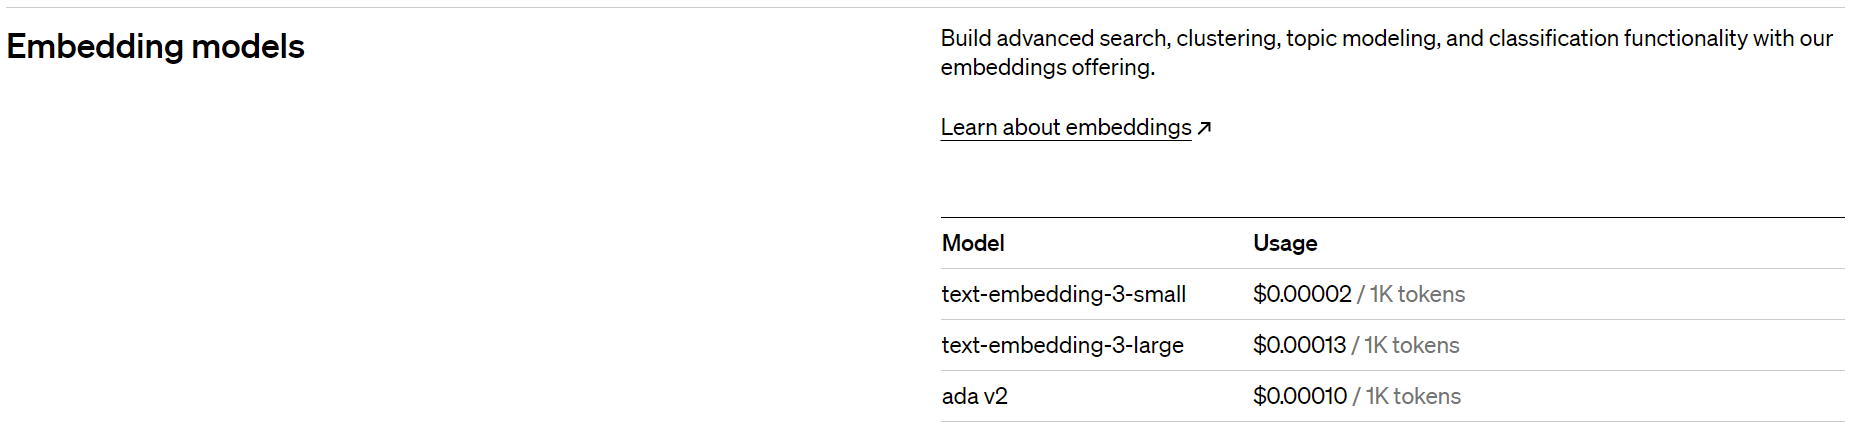

In [16]:
train_data.n_tokens_query.mean()

11.9